# Loan Prediction Project - Pipeline Construction and Modelling

Using the data preparation process we developed, we'll build a pipeline, use it to choose and tune a model, then save the model for deployment.

In [103]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
from sklearn import set_config

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# bring in dataset
df = pd.read_csv("data.csv", index_col='Loan_ID') 
# bring in balanced dataset
Bdf = pd.read_csv("balanced_data.csv", index_col='Loan_ID') 

In [3]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
Bdf.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,log_LoanAmount,total_income,log_total_income
Loan_ID,,,,,,,,,,,,,,,
LP001179,Male,Yes,2,Graduate,No,4616,0.0,134.0,360.0,1.0,Urban,N,4.897840,4616.0,8.437284
LP001691,Male,Yes,2,Not Graduate,No,3917,0.0,124.0,360.0,1.0,Semiurban,Y,4.820282,3917.0,8.273081
LP001119,Male,No,0,Graduate,No,3600,0.0,80.0,360.0,1.0,Urban,N,4.382027,3600.0,8.188689
LP001938,Male,Yes,2,Graduate,No,4400,0.0,127.0,360.0,0.0,Semiurban,N,4.844187,4400.0,8.389360
LP001750,Male,Yes,0,Graduate,No,6250,0.0,128.0,360.0,1.0,Semiurban,Y,4.852030,6250.0,8.740337


In [27]:
# assign X and y
X = df.drop(labels=['Loan_Status'], axis=1)
y = df['Loan_Status']

# select cat and con feats
cat_feats = X.select_dtypes('object').columns.tolist()
num_feats = X.select_dtypes(['int','float']).columns.tolist()

# encode y (1=approved)
label = LabelEncoder()
y = label.fit_transform(y)

In [31]:
# create convenience function for model evaluation
def evaluate(model, X_train_, X_test_, y_train_, y_test_):
    y_pred = model.predict(X_test_)
    y_train_pred = model.predict(X_train_)

    test_acc = model.score(X_test_, y_test_)
    train_acc = model.score(X_train_, y_train_)
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)

    train_probs = model.predict_proba(X_train_)[:,1]
    train_auc = roc_auc_score(y_train_,train_probs)
    print('Train auc:', train_auc)
    test_probs = model.predict_proba(X_test_)[:,1]
    test_auc = roc_auc_score(y_test_,test_probs)
    print('Test auc:', test_auc)

    train_precision = precision_score(y_train_, y_train_pred)
    test_precision = precision_score(y_test_, y_pred)
    print('Train precision:', train_precision)
    print('Test precision:', test_precision)

    train_recall = recall_score(y_train_, y_train_pred)
    test_recall = recall_score(y_test_, y_pred)
    print('Train recall:', train_recall)
    print('Test recall:', test_recall)

    train_f1 = f1_score(y_train_, y_train_pred)
    test_f1 = f1_score(y_test_, y_pred)
    print('F1 score train:', train_f1)
    print('F1 score test:', test_f1)

    cr = classification_report(y_test_,y_pred)
    print(cr)

    plot_confusion_matrix(model, X_test_, y_test_)

    plot_roc_curve(estimator=model, X=X_test_, y=y_test_)

### Pipeline Development

In [34]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [14]:
# set credit history as object
def cr_obj(data):
    data['Credit_History'] = data.Credit_History.astype('object')
    return data

credit_object = FunctionTransformer(cr_obj)

# creat function to select categorical and continuous variables
def numFeat(data):
    return data[num_feats]

def catFeat(data):
    return data[cat_feats]

# we will start two separate pipelines for each type of features
keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

# SimpleImputer for num_cols
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# SimpleImputer for cat_cols
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')

# create new total_income column
def create_total(data):
    data['total_income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
    return data

create_total_income = FunctionTransformer(create_total)

# log transform Totalamount and total_income
def log_transform(data):
    data_df = pd.DataFrame(data)
    cols = [3,5]
    for col in cols:
        data_df[col] = np.log(data_df[col])
    data_np = data_df.to_numpy()
    return data_np

logs = FunctionTransformer(log_transform)

# Densify class for cat feats after encoding
class ToDenseTransformer():
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
    def fit(self, X, y=None, **fit_params):
        return self
    
encode = OneHotEncoder()

scaler = StandardScaler()

In [15]:
# cat feats pipeline
cat_preprocessing = Pipeline([
    ('credit', credit_object),
    ('cats', keep_cat),
    ('cat_nulls', cat_imputer),
    ('encode', encode),
    ('densify', ToDenseTransformer())
])

# num feats pipeline
num_preprocessing = Pipeline([
    ('nums', keep_num),
    ('income', create_total_income),
    ('num_nulls', num_imputer),
    ('transform', logs),
    ('scale', scaler)
])

In [16]:
# combine features back together
values_union = FeatureUnion([
    ('cat_cols', cat_preprocessing),
    ('num_cols', num_preprocessing),
])

### Baseline models

#### LogisticRegression

In [35]:
model = LogisticRegression()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.8065268065268065
Test accuracy: 0.8162162162162162
Train auc: 0.8062943705629436
Test auc: 0.771048951048951
Train precision: 0.784741144414169
Test precision: 0.8243243243243243
Train recall: 0.9863013698630136
Test recall: 0.9384615384615385
F1 score train: 0.874051593323217
F1 score test: 0.8776978417266187
              precision    recall  f1-score   support

           0       0.78      0.53      0.63        55
           1       0.82      0.94      0.88       130

    accuracy                           0.82       185
   macro avg       0.80      0.73      0.75       185
weighted avg       0.81      0.82      0.80       185



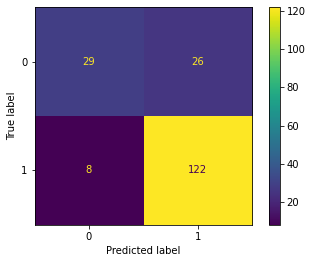

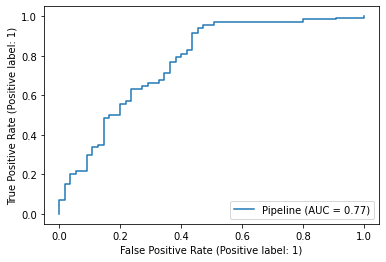

In [36]:
# predict and evaluate
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

#### Naive Bayes

In [37]:
model = GaussianNB()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.34498834498834496
Test accuracy: 0.33513513513513515
Train auc: 0.7993450654934506
Test auc: 0.7476923076923077
Train precision: 0.9230769230769231
Test precision: 1.0
Train recall: 0.0410958904109589
Test recall: 0.05384615384615385
F1 score train: 0.07868852459016394
F1 score test: 0.10218978102189781
              precision    recall  f1-score   support

           0       0.31      1.00      0.47        55
           1       1.00      0.05      0.10       130

    accuracy                           0.34       185
   macro avg       0.65      0.53      0.29       185
weighted avg       0.79      0.34      0.21       185



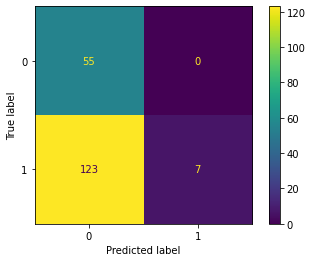

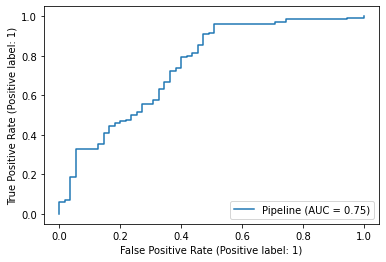

In [38]:
# predict and evaluate
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

#### SVM Classifier

In [42]:
model = SVC(probability=True)

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.8205128205128205
Test accuracy: 0.827027027027027
Train auc: 0.906084391560844
Test auc: 0.745034965034965
Train precision: 0.7945205479452054
Test precision: 0.8181818181818182
Train recall: 0.9931506849315068
Test recall: 0.9692307692307692
F1 score train: 0.8828006088280062
F1 score test: 0.8873239436619719
              precision    recall  f1-score   support

           0       0.87      0.49      0.63        55
           1       0.82      0.97      0.89       130

    accuracy                           0.83       185
   macro avg       0.84      0.73      0.76       185
weighted avg       0.83      0.83      0.81       185



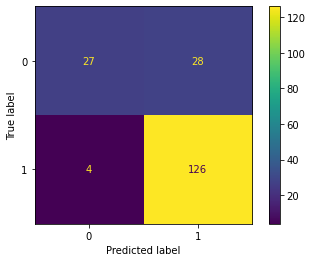

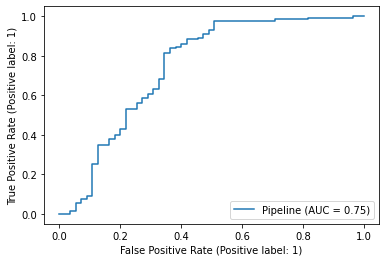

In [43]:
# predict and evaluate
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

#### Random Forest

In [45]:
model = RandomForestClassifier()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 1.0
Test accuracy: 0.7837837837837838
Train auc: 1.0
Test auc: 0.7900699300699301
Train precision: 1.0
Test precision: 0.8169014084507042
Train recall: 1.0
Test recall: 0.8923076923076924
F1 score train: 1.0
F1 score test: 0.8529411764705882
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        55
           1       0.82      0.89      0.85       130

    accuracy                           0.78       185
   macro avg       0.75      0.71      0.72       185
weighted avg       0.77      0.78      0.78       185



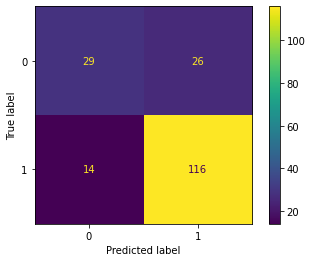

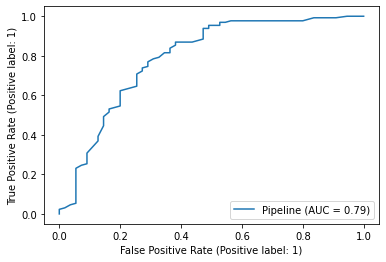

In [46]:
# predict and evaluate
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

#### XGBoost

In [48]:
model = XGBClassifier()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

[16:36:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 1.0
Test accuracy: 0.7621621621621621
Train auc: 1.0
Test auc: 0.7620979020979021
Train precision: 1.0
Test precision: 0.8307692307692308
Train recall: 1.0
Test recall: 0.8307692307692308
F1 score train: 1.0
F1 score test: 0.8307692307692308
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        55
           1       0.83      0.83      0.83       130

    accuracy                           0.76       185
   macro avg       0.72      0.72      0.72       185
weighted avg       0.76      0.76      0.76       185



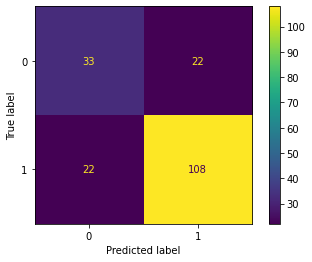

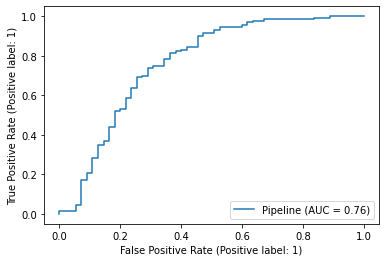

In [49]:
# predict and evaluate
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

#### Gradient Boosting Classifier

In [51]:
model = GradientBoostingClassifier()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.9347319347319347
Test accuracy: 0.8054054054054054
Train auc: 0.988976102389761
Test auc: 0.7793006993006993
Train precision: 0.9125
Test precision: 0.8405797101449275
Train recall: 1.0
Test recall: 0.8923076923076924
F1 score train: 0.9542483660130718
F1 score test: 0.8656716417910447
              precision    recall  f1-score   support

           0       0.70      0.60      0.65        55
           1       0.84      0.89      0.87       130

    accuracy                           0.81       185
   macro avg       0.77      0.75      0.76       185
weighted avg       0.80      0.81      0.80       185



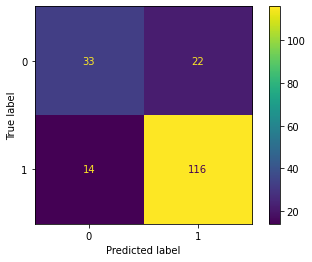

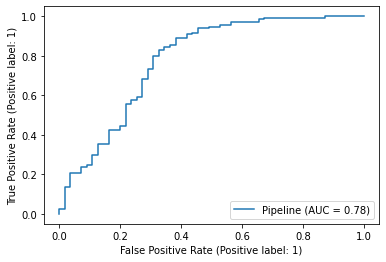

In [52]:
# predict and evaluate
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

Best performace with a non-ensemble model was SVC, we'll explore that further.
<br>Ensemble methods tended to overfit, so we'll explore some parameter options to try and address it. We'll use Random Forest as it had the highest auc score.
<br>We'll also try adding some feature selection to our pipeline to see if it helps performance

### Feature Selection

In [66]:
# create pca and kbest and merge with featureunion

# can experiment with number of components in grid search if needed
pca = PCA(n_components=5)
kbest = SelectKBest(k=5)

feature_union = FeatureUnion([
    ('pca', pca),
    ('select_best', kbest)
])

In [67]:
# try SVC with feature selection
model = SVC(probability=True)

feat_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('features', feature_union),
    ('classifier', model)
])

# fit pipeline
feat_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.8158508158508159
Test accuracy: 0.827027027027027
Train auc: 0.8744625537446256
Test auc: 0.7741258741258741
Train precision: 0.7901907356948229
Test precision: 0.8181818181818182
Train recall: 0.9931506849315068
Test recall: 0.9692307692307692
F1 score train: 0.8801213960546282
F1 score test: 0.8873239436619719
              precision    recall  f1-score   support

           0       0.87      0.49      0.63        55
           1       0.82      0.97      0.89       130

    accuracy                           0.83       185
   macro avg       0.84      0.73      0.76       185
weighted avg       0.83      0.83      0.81       185



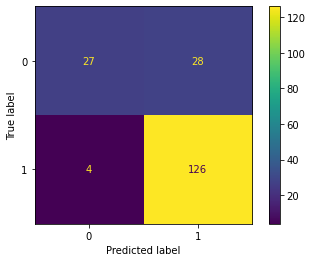

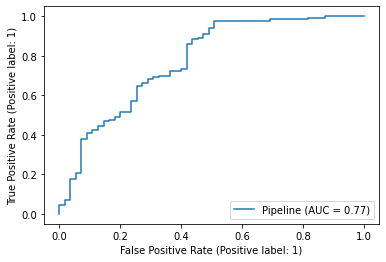

In [68]:
# predict and evaluate
evaluate(feat_pipeline, X_train, X_test, y_train, y_test)

Feature selection does not seem to improve performace in this case, so we'll move forward without it for now.

#### SVC Parameter tuning

In [82]:
# use grid search to tune SVC parameters
scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer()]

model = SVC(probability=True)

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

params = {
    'classifier__C': [5, 7, 9],
    'classifier__kernel': ['linear', 'poly', 'rbf'],
    'classifier__degree': [2,3,4],
    'classifier__random_state': [23]
    'values__num_cols__scale': scalers_to_test
    }

k_folds = 5

grid_search = GridSearchCV(base_pipeline, param_grid=params, verbose=1, refit=True, cv=k_folds)

# fit
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('values',
                                        FeatureUnion(transformer_list=[('cat_cols',
                                                                        Pipeline(steps=[('credit',
                                                                                         FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                                        ('cats',
                                                                                         FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                                        ('cat_nulls',
                                                                                         SimpleImputer(fill_value='unknown',
                                                                                                       strategy='cons

In [83]:
print(grid_search.best_params_)
cl = grid_search.best_estimator_

{'classifier__C': 5, 'classifier__degree': 2, 'classifier__kernel': 'linear', 'values__num_cols__scale': StandardScaler()}


Train accuracy: 0.8018648018648019
Test accuracy: 0.827027027027027
Train auc: 0.767073292670733
Test auc: 0.773006993006993
Train precision: 0.7789757412398922
Test precision: 0.8181818181818182
Train recall: 0.9897260273972602
Test recall: 0.9692307692307692
F1 score train: 0.8717948717948718
F1 score test: 0.8873239436619719
              precision    recall  f1-score   support

           0       0.87      0.49      0.63        55
           1       0.82      0.97      0.89       130

    accuracy                           0.83       185
   macro avg       0.84      0.73      0.76       185
weighted avg       0.83      0.83      0.81       185



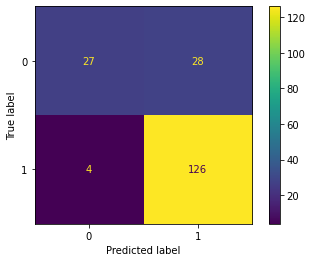

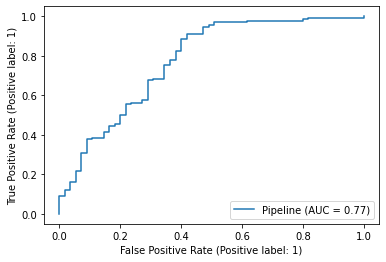

In [85]:
# predict and evaluate
evaluate(cl, X_train, X_test, y_train, y_test)

#### Random Forest parameter tuning

In [86]:
model = RandomForestClassifier()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

params = {
    'classifier__n_estimators': [15, 25, 50, 100],
    'classifier__max_depth': [3,4, 5],
    'classifier__random_state': [23],
    'values__num_cols__scale': scalers_to_test
    }

k_folds = 5

grid_search = GridSearchCV(base_pipeline, param_grid=params, verbose=1, refit=True, cv=k_folds)

# fit
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('values',
                                        FeatureUnion(transformer_list=[('cat_cols',
                                                                        Pipeline(steps=[('credit',
                                                                                         FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                                        ('cats',
                                                                                         FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                                        ('cat_nulls',
                                                                                         SimpleImputer(fill_value='unknown',
                                                                                                       strategy='cons

In [87]:
print(grid_search.best_params_)
cl = grid_search.best_estimator_

{'classifier__max_depth': 3, 'classifier__n_estimators': 15, 'classifier__random_state': 23, 'values__num_cols__scale': StandardScaler()}


Train accuracy: 0.7925407925407926
Test accuracy: 0.7891891891891892
Train auc: 0.8614388561143885
Test auc: 0.7866433566433566
Train precision: 0.7678100263852242
Test precision: 0.782608695652174
Train recall: 0.9965753424657534
Test recall: 0.9692307692307692
F1 score train: 0.8673621460506706
F1 score test: 0.865979381443299
              precision    recall  f1-score   support

           0       0.83      0.36      0.51        55
           1       0.78      0.97      0.87       130

    accuracy                           0.79       185
   macro avg       0.81      0.67      0.69       185
weighted avg       0.80      0.79      0.76       185



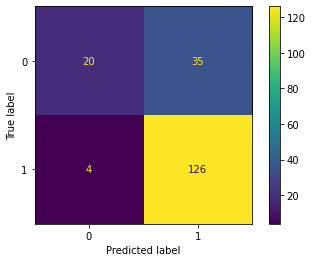

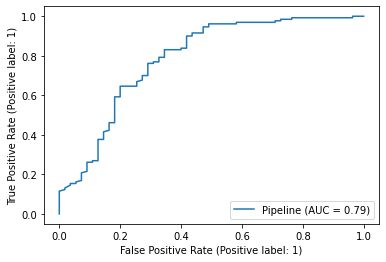

In [88]:
# predict and evaluate
evaluate(cl, X_train, X_test, y_train, y_test)

We were able to address overfitting in the Random Forest model, but still get slightly better performance with SVC

#### Balanced dataset

In [93]:
# assign balanced X and y
BX = Bdf.drop(labels=['Loan_Status'], axis=1)
By = Bdf['Loan_Status']

# encode y (1=approved)
label = LabelEncoder()
By = label.fit_transform(By)

# create balanced test train split
BX_train, BX_test, By_train, By_test = train_test_split(BX, By, test_size=0.3, random_state=21)

In [99]:
# SVC, with parameters from grid search
model = SVC(probability=True, kernel='linear', C=5)

tuned_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
tuned_pipeline.fit(BX_train, By_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.7338983050847457
Test accuracy: 0.7637795275590551
Train auc: 0.7734569816481078
Test auc: 0.788093023255814
Train precision: 0.6674876847290641
Test precision: 0.7017543859649122
Train recall: 0.9249146757679181
Test recall: 0.9302325581395349
F1 score train: 0.7753934191702432
F1 score test: 0.8
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       125
           1       0.70      0.93      0.80       129

    accuracy                           0.76       254
   macro avg       0.80      0.76      0.76       254
weighted avg       0.80      0.76      0.76       254



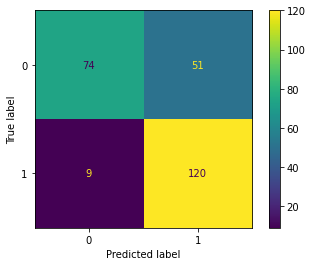

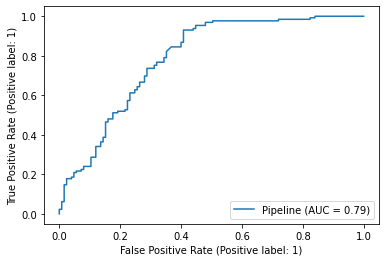

In [100]:
# predict and evaluate
evaluate(tuned_pipeline, BX_train, BX_test, By_train, By_test)

In [96]:
# RandomForest with balanced dataset
model = RandomForestClassifier(n_estimators=15, max_depth=3)

tuned_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
tuned_pipeline.fit(BX_train, By_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.7491525423728813
Test accuracy: 0.7559055118110236
Train auc: 0.8647223084083152
Test auc: 0.8211782945736434
Train precision: 0.6772616136919315
Test precision: 0.6914285714285714
Train recall: 0.9453924914675768
Test recall: 0.937984496124031
F1 score train: 0.7891737891737891
F1 score test: 0.7960526315789473
              precision    recall  f1-score   support

           0       0.90      0.57      0.70       125
           1       0.69      0.94      0.80       129

    accuracy                           0.76       254
   macro avg       0.80      0.75      0.75       254
weighted avg       0.79      0.76      0.75       254



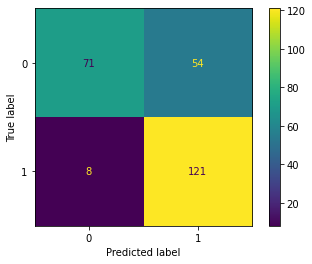

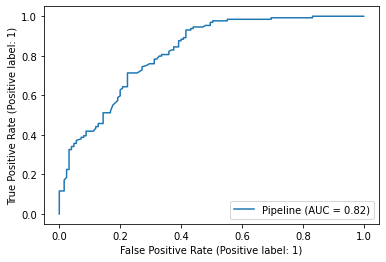

In [97]:
# predict and evaluate
evaluate(tuned_pipeline, BX_train, BX_test, By_train, By_test)

#### Model Selection

In this case we'll choose the SVC model on the unbalanced dataset. Although modelling with the balanced dataset led to better classifaction of the '0' label (not approved), training with an unbalanced dataset led to slightly better classification of the '1' label (approved).

In this case we assumed the goal of such a prediction tool would be for the initial screening of applications, and applicants who proceeded past this first step would be further evaluated for loan suitability. In this scenario, a lender would want to avoid misclassifying eligible applicants (and thus losing business), while still filtering out unsuitable applicants. If our model were used approximately 50% of unsuitable applicants would be identified during the screening, and only 3% of eligible applicants would be incorrectly screened out.

In [101]:
# train final model
# SVC, with parameters from grid search
model = SVC(probability=True, kernel='linear', C=5)

tuned_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline on unbalanced dataset
tuned_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                         

Train accuracy: 0.8018648018648019
Test accuracy: 0.827027027027027
Train auc: 0.767073292670733
Test auc: 0.773006993006993
Train precision: 0.7789757412398922
Test precision: 0.8181818181818182
Train recall: 0.9897260273972602
Test recall: 0.9692307692307692
F1 score train: 0.8717948717948718
F1 score test: 0.8873239436619719
              precision    recall  f1-score   support

           0       0.87      0.49      0.63        55
           1       0.82      0.97      0.89       130

    accuracy                           0.83       185
   macro avg       0.84      0.73      0.76       185
weighted avg       0.83      0.83      0.81       185



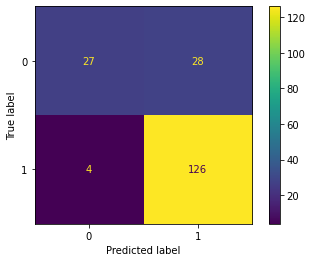

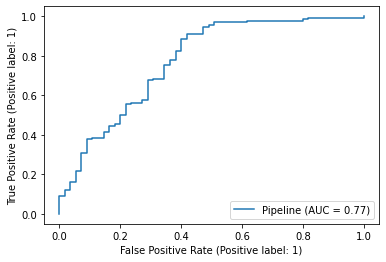

In [102]:
# double check results
evaluate(tuned_pipeline, X_train, X_test, y_train, y_test)

In [104]:
# show final pipeline configuration
set_config(display='diagram')
tuned_pipeline

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function cr_obj at 0x7fdcc20c6ca0>)),
                                                                 ('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7fdcc20c6f70>)),
                                                                 ('cat_nulls',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseT...
                                                                  FunctionTransformer(func=<function numFeat at 0x7fdcc20c6ee0>)),
                                                                 ('income',
                                                                  FunctionTransformer(func=<function create_total at 0x7fdcc20e4040>)),
                                                                 ('num_nulls',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('transform',
                                                                  FunctionTransformer(func=<function log_transform at 0x7fdcc20e40d0>)),
                                                                 ('scale',
                                                                  StandardScaler())]))])),
                ('classifier', SVC(C=5, kernel='linear', probability=True))])

In [105]:
# save final model to disk for later deployment
filename = 'loan_prediction_model.sav'
pickle.dump(tuned_pipeline, open(filename, 'wb'))